In [1]:
## general imports
import json
import numpy as np

## COCO imports
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools.cocoanalyze import COCOanalyze

## plotting imports
%matplotlib inline
import matplotlib.pyplot as plt
import skimage.io as io

In [2]:
## set paths
dataDir  = '.'
dataType = 'testdev2015'
annType  = 'keypoints'
teamName = 'cmu' #maskrnn9 cmu

annFile  = '%s/annotations/%s_%s.json'%(dataDir, annType, dataType)
resFile  = '%s/detections/%s_%s_%s_results.json'%(dataDir, teamName, annType, dataType)

print("{:10}[{}]".format('annFile:',annFile))
print("{:10}[{}]".format('resFile:',resFile))

gt_data   = json.load(open(annFile,'rb'))
imgs_info = {i['id']:{'id':i['id'] ,
                      'width':i['width'],
                      'height':i['height']}
                       for i in gt_data['images']}

annFile:  [./annotations/keypoints_testdev2015.json]
resFile:  [./detections/cmu_keypoints_testdev2015_results.json]


In [3]:
team_dts = json.load(open(resFile,'rb'))
team_dts = [d for d in team_dts if d['image_id'] in imgs_info]
team_img_ids = set([d['image_id'] for d in team_dts])
print("Loaded [{}] instances in [{}] images.".format(len(team_dts),len(imgs_info)))

## load ground truth annotations
coco_gt = COCO( annFile )

## initialize COCO detections api
coco_dt   = coco_gt.loadRes( team_dts )

## initialize COCO analyze api
coco_analyze = COCOanalyze(coco_gt, coco_dt, 'keypoints')

Loaded [47925] instances in [20288] images.
loading annotations into memory...
Done (t=1.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.04s)
creating index...
index created!


In [4]:
# use evaluate() method for standard coco evaluation
# input arguments:
#  - verbose   : verbose outputs    (default: False)
#  - makeplots : plots eval results (default: False)
#  - savedir   : path to savedir    (default: None)
#  - team_name : team name string   (default: None)

#coco_analyze.evaluate(verbose=True, makeplots=True)

In [5]:
## NOTE: the values below are all default

# set OKS threshold of the extended error analysis
coco_analyze.params.oksThrs       = [.5,.55,.6,.65,.7,.75,.8,.85,.9,.95]

# set OKS threshold required to match a detection to a ground truth
coco_analyze.params.oksLocThrs    = .1

# set KS threshold limits defining jitter errors
coco_analyze.params.jitterKsThrs = [.5,.85]

# set the localization errors to analyze and in what order
# note: different order will show different progressive improvement
# to study impact of single error type, study in isolation
coco_analyze.params.err_types = ['miss','swap','inversion','jitter']

# area ranges for evaluation
# 'all' range is union of medium and large
coco_analyze.params.areaRng       = [[32 ** 2, 96 ** 2]] #[[96 ** 2, 1e5 ** 2],[32 ** 2, 96 ** 2],[32 ** 2, 1e5 ** 2]]
coco_analyze.params.areaRngLbl    = ['medium']               #['large','medium','all']

coco_analyze.params.maxDets = [20]

In [6]:
# use analyze() method for advanced error analysis 
# input arguments:
#  - check_kpts   : analyze keypoint localization errors for detections with a match (default: True)
#                 : errors types are ['jitter','inversion','swap','miss']
#  - check_scores : analyze optimal score (maximizing oks over all matches) for every detection (default: True)
#  - check_bkgd   : analyze background false positives and false negatives (default: True)

coco_analyze.analyze(check_kpts=False, check_scores=True, check_bckgd=True)

<mrr:2.0>Analyzing detection scores...
<mrr:2.0>Running per image *optimal score* evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=9.69s).
<mrr:2.0>DONE (t=9.71s).
<mrr:2.0>Analyzing background false positives and false negatives...
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=9.71s).
<mrr:2.0>DONE (t=12.19s).


In [7]:
#coco_analyze.evaluate(verbose=True, makeplots=True)

<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=9.90s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.10s).
<mrr:2.0>Correcting area range [medium]:
<mrr:2.0>Correcting error type [score]:
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=9.21s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.09s).
<mrr:2.0>Correcting area range [medium]:
<mrr:2.0>Correcting error type [bckgd. fp, fn]:
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=10.02s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.08s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.08s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.08s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.08s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.09s).
<mrr:2.0>A

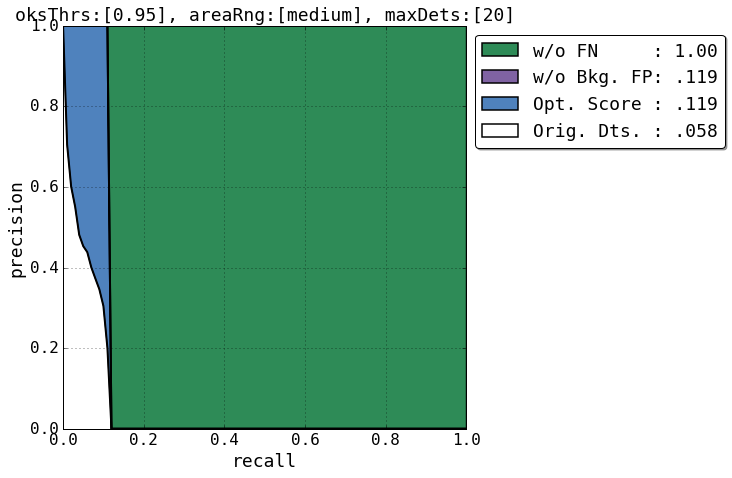

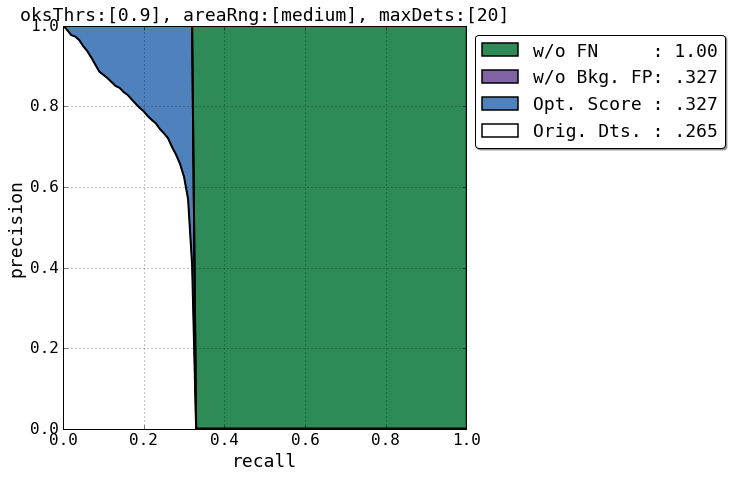

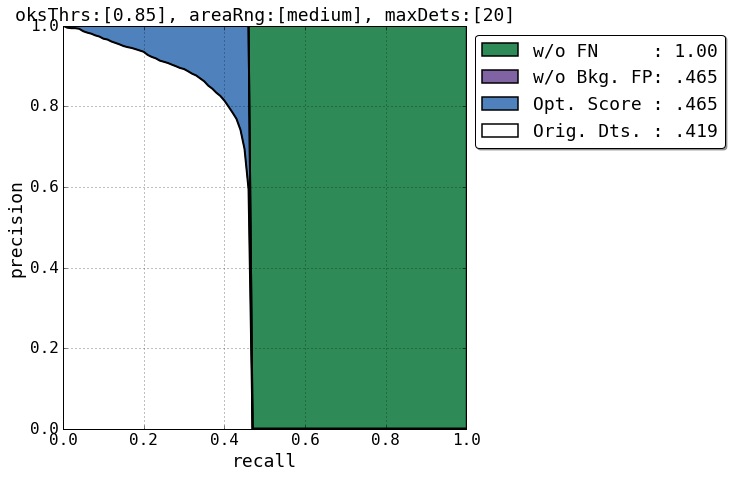

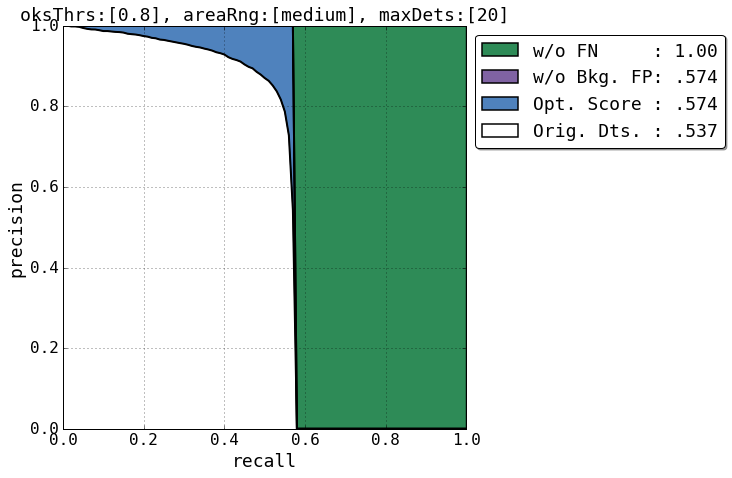

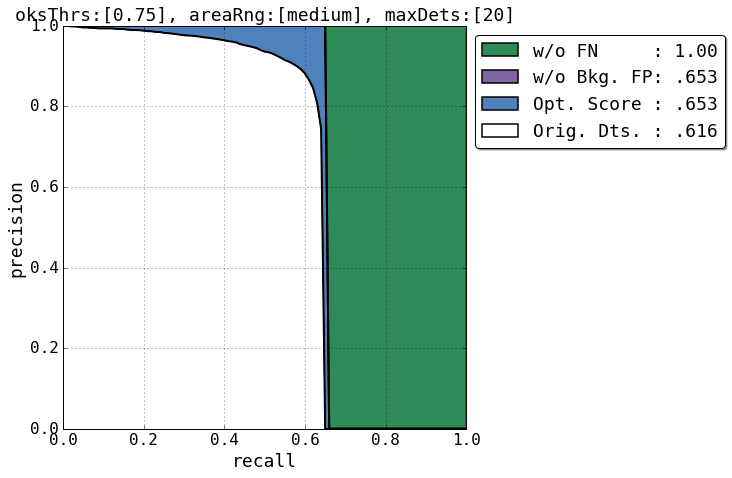

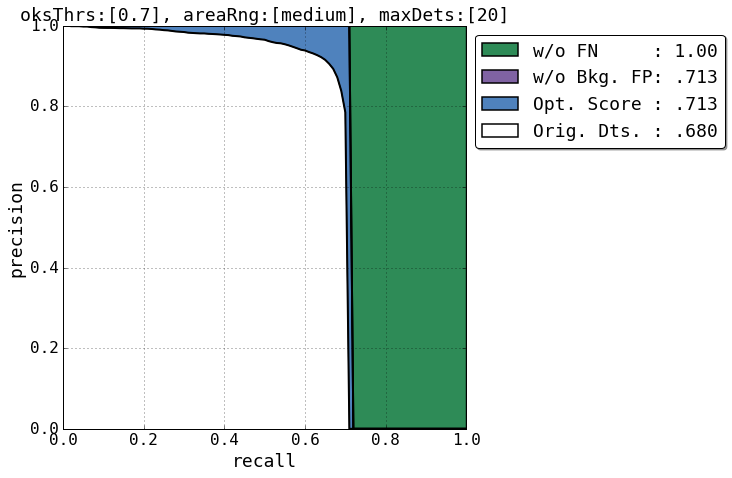

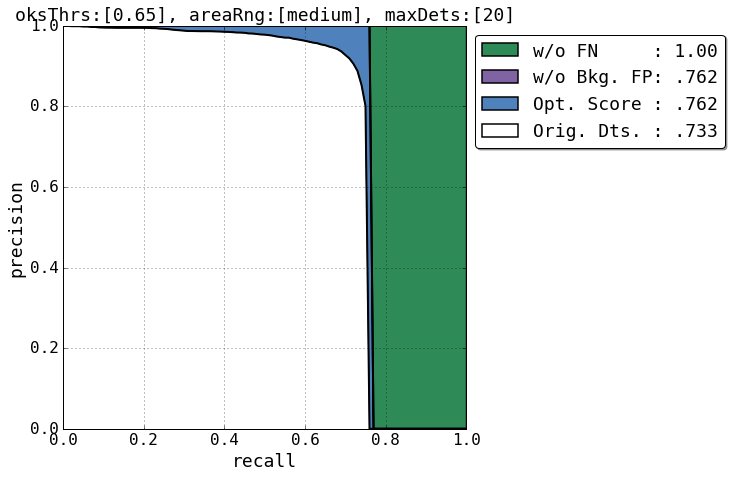

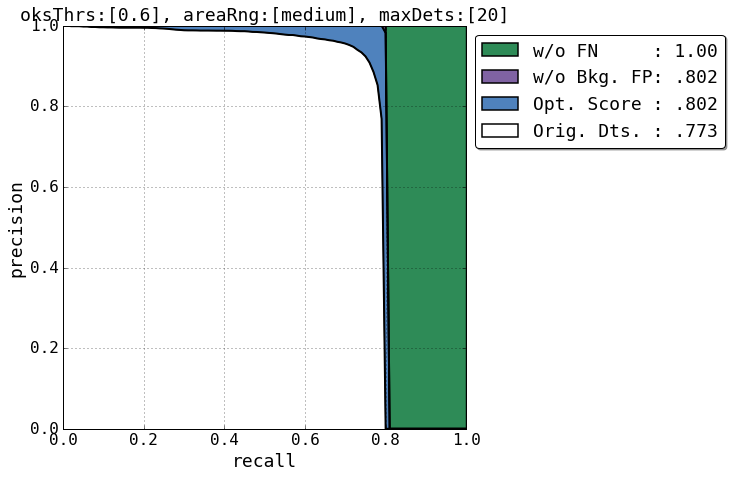

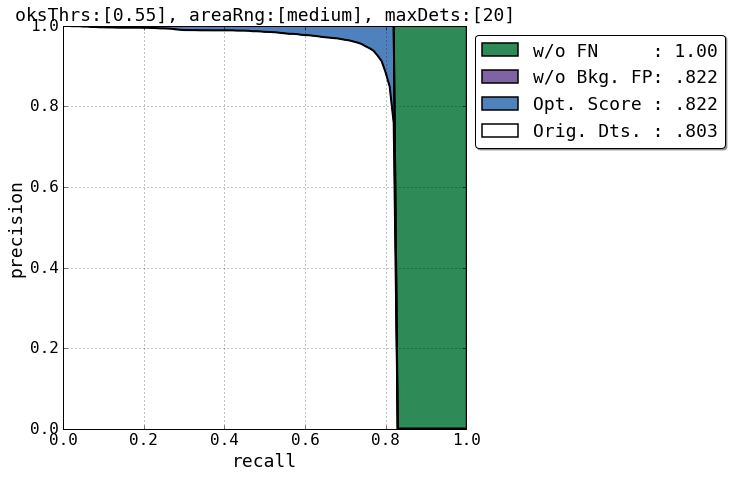

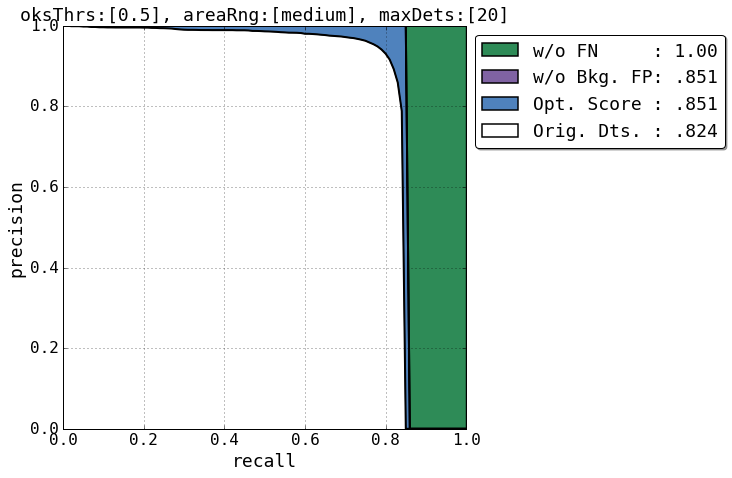

In [8]:
# use summarize() method to get the results after progressive correction of errors
# input arguments:
#  - makeplots : plots eval results (default: False)
#  - savedir   : path to savedir    (default: None)
#  - team_name : team name string   (default: None)

coco_analyze.summarize(makeplots=True)

In [10]:
weird = {}
for d in coco_analyze.corrected_dts['medium']:
    for oks in [.5,.55,.6,.65,.7,.75,.8,.85,.9,.95]:
        if d['id'] in coco_analyze.false_pos_dts['medium',oks] and d['opt_score']!=0:
            if oks in weird:
                weird[oks].append(d)
            else:
                weird[oks] = [d]
                
for l in weird:
    print l, len(weird[l])

0.75 3016
0.5 932
0.55 1169
0.8 3833
0.6 1478
0.85 4931
0.9 6435
0.7 2371
0.95 8761
0.65 1866


In [ ]:
for k in coco_analyze.false_pos_dts: print k, len(coco_analyze.false_pos_dts[k]), type(coco_analyze.false_pos_dts[k])
print "============"
for d in list(coco_analyze.false_pos_dts['medium',.6])[:10]: print d

In [ ]:
print type(coco_analyze.corrected_dts), len(coco_analyze.corrected_dts)
print coco_analyze.corrected_dts.keys()

print type(coco_analyze.localization_matches), len(coco_analyze.localization_matches)
print coco_analyze.localization_matches.keys()

In [ ]:
## after analyze() has been called the following variables are available

# list of the corrected detections
corrected_dts = coco_analyze.corrected_dts

i = 17
# info on keypoint detection localization error
print 'good: %s'%corrected_dts[i]['good']
print 'miss: %s'%corrected_dts[i]['miss']
print 'swap: %s'%corrected_dts[i]['swap']
print 'inv.: %s'%corrected_dts[i]['inversion']
print 'jit.: %s\n'%corrected_dts[i]['jitter']

# corrected keypoint locations
print 'predicted keypoints:\n %s'%corrected_dts[i]['keypoints']
print 'corrected keypoints:\n %s\n'%corrected_dts[i]['opt_keypoints']

# optimal detection score
print 'original score: %s'%corrected_dts[i]['score']
print 'optimal score:  %s\n'%corrected_dts[i]['opt_score']

# dictionary with all detection and ground truth matches
dt_gt_matches = coco_analyze.matches
print "Dt-gt match:"
for k in dt_gt_matches['dts'][corrected_dts[i]['id']][0]:
    print k, dt_gt_matches['dts'][corrected_dts[i]['id']][0][k]

In [ ]:
## after summarize() has been called the following variables are available

# list of the missed ground-truth annotations
false_neg_gts = coco_analyze.false_neg_gts

In [ ]:
## list the performance summary 
for stat in coco_analyze.stats: print stat